In [8]:
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [ ]:
path = "./stock_price.csv"
df = pd.read_csv(path)

In [ ]:
def convert_volume(value):
    number = float(re.sub(r"[BM]", "", str(value)))
    if "B" in str(value):
        return number * 1000000000
    elif "M" in str(value):
        return number * 1000000
    else:
        return number

features = df[["終値", "始値", "高値", "安値", "出来高", "変化率 %"]].copy()
features["出来高"] = features["出来高"].apply(convert_volume)
features["変化率 %"] = features["変化率 %"].str.replace("%", "").astype(float)
features = features.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(features)
features_scaled = scaler.transform(features)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        """
        一層LSTMを用いたseq2one時系列予測モデル

            (batch, len_seq, input_size) -> (batch, input_size)

        Params:
            input_size: int 入力のチャネル数
            hidden_size: int 内部隠れ変数の次元
            output_size: int 出力のチャネル数
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x_last = x[:, -1, :]
        x = self.linear(x_last)

        return x

In [ ]:
def get_seq(data, timestep):
    if len(data) < timestep:
        raise ValueError("invalid timestep")

    X = []
    y = []

    for i in range(len(data) - timestep - 1):
        X.append(data[i : i + timestep, :])
        y.append(data[i + timestep, 0])

    X, y = np.array(X), np.array(y).reshape(-1, 1)

    return X, y

In [13]:
# nの候補
ns = [5, 10, 25, 50, 75, 100]

valids = {}

for n in ns:
    model = LSTMModel(input_size=6)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    X, y = get_seq(features_scaled, n)
    X, y = torch.FloatTensor(X), torch.FloatTensor(y)

    train_size = int(len(X) * 0.70)
    valid_size = int(len(X) * 0.15)
    X_train, X_valid, X_test = (
        X[:train_size, :],
        X[train_size : train_size + valid_size, :],
        X[train_size + valid_size :, :],
    )
    y_train, y_valid, y_test = (
        y[:train_size, :],
        y[train_size : train_size + valid_size, :],
        y[train_size + valid_size :, :],
    )

    batch_size = 32
    dataset_train = TensorDataset(X_train, y_train)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

    epochs = 50
    losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0
        for inputs, labels in loader_train:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        losses.append(total_loss)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()

    y_test = y_test.numpy()

    # 1次元の予測値を3次元に拡張して逆変換
    _y_pred = np.zeros((len(y_pred), 6))
    _y_pred[:, 0] = y_pred.flatten()
    y_pred_inverted = scaler.inverse_transform(_y_pred)[:, 0:1]

    # テストデータも同様
    _y_test = np.zeros((len(y_test), 6))
    _y_test[:, 0] = y_test.flatten()
    y_test_inverted = scaler.inverse_transform(_y_test)[:, 0:1]

    # 誤差計算
    mse_inv = np.mean((y_pred_inverted - y_test_inverted) ** 2)
    rmse_inv = np.sqrt(mse_inv)
    mape = np.mean(np.abs((y_pred_inverted - y_test_inverted) / y_test_inverted))

    valids[n] = {"mse_inv": mse_inv, "rmse_inv": rmse_inv, "mape": mape}


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


In [14]:
rmses = [(n, valids[n]["rmse_inv"].item()) for n in ns]
mapes = [(n, valids[n]["mape"].item()) for n in ns]

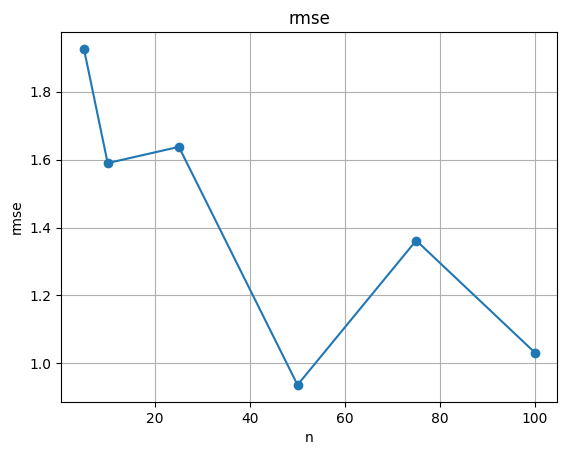

In [ ]:
x_values, y_values = zip(*rmses)

# 折れ線グラフをプロット
plt.plot(x_values, y_values, marker="o", linestyle="-")
plt.xlabel("n")
plt.ylabel("rmse")
plt.title("rmse")
plt.grid(True)
plt.show()

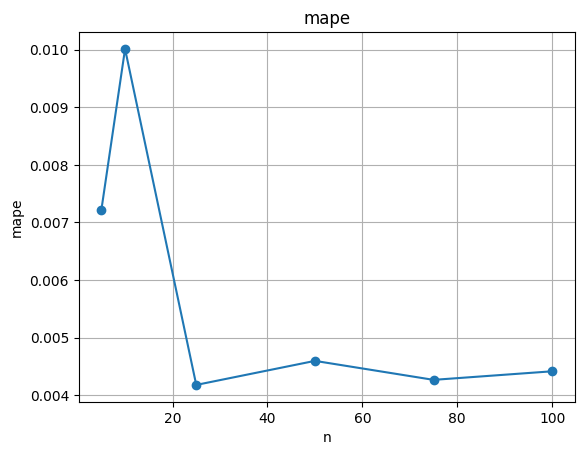

In [ ]:
x_values, y_values = zip(*mapes)

# 折れ線グラフをプロット
plt.plot(x_values, y_values, marker="o", linestyle="-")
plt.xlabel("n")
plt.ylabel("mape")
plt.title("mape")
plt.grid(True)
plt.show()